In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
%config Completer.use_jedi = False

In [2]:
(Path.cwd().parent.parent)

WindowsPath('c:/Users/jaesc2/GitHub')

## Librerias

In [3]:
## ForecasterAutoregMultiSeries
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

from skforecast.utils import check_y
from skforecast.utils import check_exog
from skforecast.utils import preprocess_y
from skforecast.utils import preprocess_last_window
from skforecast.utils import preprocess_exog
from skforecast.utils import expand_index
from skforecast.utils import check_predict_input


from xgboost import XGBRegressor

In [4]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean'})

data.head()

# Split data into train-val-test
# ==============================================================================
data = data.loc['2014-06-01 00:00:00': '2014-07-31 23:59:00']
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates  : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


<AxesSubplot:xlabel='Time'>

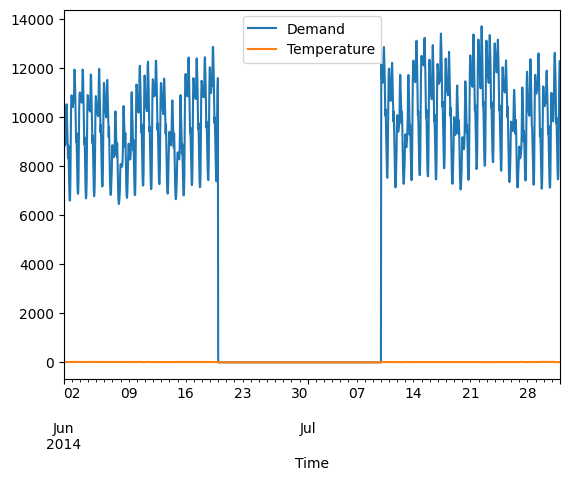

In [5]:
data.loc['2014-06-20 00:00:00':'2014-07-10 00:00:00', :] = 0
data_train.loc['2014-06-20 00:00:00':'2014-07-10 00:00:00', :] = 0
data.plot()

In [6]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
                 series_weights     = {'Demand': 1, 'Temperature': 1},
             )
X_train, y_train, y_index, y_train_index = forecaster.create_train_X_y(series=data_train)

In [7]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
                 series_weights     = {'Demand': 1, 'Temperature': 1},
             )

forecaster.fit(series=data_train[['Demand', 'Temperature']])
forecaster

ForecasterAutoregMultiSeries 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: {'Demand': None, 'Temperature': None} 
Transformer for exog: None 
Window size: 24 
Series levels (names): ['Demand', 'Temperature'] 
Series weights: {'Demand': 1, 'Temperature': 1} 
Included weights function: False 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-06-01 00:00:00'), Timestamp('2014-07-15 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-10-28 20:48:13 
Last fit date: 2022-10-28 20:48:13 
Skforecast version: 0.6.dev 
Python version: 3.8.13 

In [8]:
# Backtesting Multi Series
# ==============================================================================
metric, predictions_item_1 = backtesting_forecaster_multiseries(
                                 forecaster         = forecaster,
                                 series             = data,
                                 levels             = None,
                                 initial_train_size = len(data_train),
                                 fixed_train_size   = True,
                                 steps              = 24,
                                 metric             = 'mean_absolute_error',
                                 refit              = False,
                                 verbose            = False
                             )

display(metric)
display(predictions_item_1.head(4))

,levels,mean_absolute_error
0,Demand,748.199135
1,Temperature,1.950579


,Demand,Temperature
2014-07-16 00:00:00,12352.905196,10.566879
2014-07-16 01:00:00,12212.511514,10.927237
2014-07-16 02:00:00,12018.315847,11.274122
2014-07-16 03:00:00,11963.606984,11.376573


In [9]:
# Custom function to create weights
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is one between 2014-06-20 and 2014-06-30.
    """
    weights = np.where(
                (index >= '2014-06-20') & (index <= '2014-07-10'),
                0,
                1

              )
    return weights

# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
                 series_weights     = {'Demand': 1, 'Temperature': 1},
                 weight_func        = custom_weights
             )

# Backtesting Multi Series
# ==============================================================================
metric, predictions_item_1 = backtesting_forecaster_multiseries(
                                 forecaster         = forecaster,
                                 series             = data,
                                 levels             = None,
                                 initial_train_size = len(data_train),
                                 fixed_train_size   = True,
                                 steps              = 24,
                                 metric             = 'mean_absolute_error',
                                 refit              = False,
                                 verbose            = False
                             )

display(metric)
display(predictions_item_1.head(4))

,levels,mean_absolute_error
0,Demand,662.387693
1,Temperature,1.869881


,Demand,Temperature
2014-07-16 00:00:00,12271.512063,10.625944
2014-07-16 01:00:00,12090.601456,11.070533
2014-07-16 02:00:00,11853.600824,11.553760
2014-07-16 03:00:00,11734.713050,11.787373


In [10]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
                 series_weights     = {'Demand': 0.1, 'Temperature': 1000}
             )


# Grid search Multi Series
# ==============================================================================
lags_grid = [24, 48]
param_grid = {'alpha': [0.01, 0.1, 1]}

levels = ['Demand', 'Temperature']

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              steps               = 24,
              metric              = 'mean_absolute_error',
              initial_train_size  = len(data_train),
              fixed_train_size    = True,
              levels              = levels,
              exog                = None,
              refit               = True,
              return_best         = False,
              verbose             = False
          )

results

6 models compared for 2 level(s). Number of iterations: 6.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]


,levels,lags,params,mean_absolute_error,alpha
3,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},278.891242,0.01
4,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},278.893256,0.10
5,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},278.913185,1.00
0,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},372.929113,0.01
1,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},372.932835,0.10
2,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},372.969769,1.00


## Predict_interval

In [4]:
series = pd.DataFrame({'1': pd.Series(np.array(
                                [0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
                                 0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
                                 0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
                                 0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                                 0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
                                 0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
                                 0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
                                 0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
                                 0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
                                 0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]
                                )
                            ), 
                       '2': pd.Series(np.array(
                                [0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
                                 0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
                                 0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
                                 0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
                                 0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
                                 0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
                                 0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
                                 0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
                                 0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
                                 0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601]
                                )
                            )
                      }
         )
    
exog = pd.DataFrame({'col_1': pd.Series(np.array(
                                [0.51312815, 0.66662455, 0.10590849, 0.13089495, 0.32198061,
                                 0.66156434, 0.84650623, 0.55325734, 0.85445249, 0.38483781,
                                 0.3167879 , 0.35426468, 0.17108183, 0.82911263, 0.33867085,
                                 0.55237008, 0.57855147, 0.52153306, 0.00268806, 0.98834542,
                                 0.90534158, 0.20763586, 0.29248941, 0.52001015, 0.90191137,
                                 0.98363088, 0.25754206, 0.56435904, 0.80696868, 0.39437005,
                                 0.73107304, 0.16106901, 0.60069857, 0.86586446, 0.98352161,
                                 0.07936579, 0.42834727, 0.20454286, 0.45063649, 0.54776357,
                                 0.09332671, 0.29686078, 0.92758424, 0.56900373, 0.457412  ,
                                 0.75352599, 0.74186215, 0.04857903, 0.7086974 , 0.83924335]
                                )
                              ),
                     'col_2': ['a']*25 + ['b']*25}
       )

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

transformer_exog = ColumnTransformer(
                            [('scale', StandardScaler(), ['col_1']),
                             ('onehot', OneHotEncoder(), ['col_2'])],
                            remainder = 'passthrough',
                            verbose_feature_names_out = False
                       )
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LinearRegression(),
                 lags = 5,
                 transformer_series = StandardScaler(),
                 transformer_exog = transformer_exog,
             )
forecaster.fit(series=series, exog=exog)
predictions = forecaster.predict_interval(steps=5, levels='1', exog=exog)
expected = pd.DataFrame(
               data = np.array([[0.53267333, 0.17691231, 0.9399491 ],
                                [0.44478046, 0.04641456, 0.83203647],
                                [0.52579563, 0.13671047, 0.92765308],
                                [0.57391142, 0.21373477, 0.97709097],
                                [0.54633594, 0.1725495 , 0.94995973]]),
               index = pd.RangeIndex(start=50, stop=55, step=1),
               columns = ['1', '1_lower_bound', '1_upper_bound']
           )

pd.testing.assert_frame_equal(predictions, expected)

In [10]:
predictions = forecaster.predict_interval(steps=5, levels=['1', '2'], exog=exog)
predictions

,1,1_lower_bound,1_upper_bound,2,2_lower_bound,2_upper_bound
50,0.532673,0.176912,0.939949,0.554964,0.147142,0.924642
51,0.444780,0.046415,0.832036,0.577880,0.144505,0.933736
52,0.525796,0.136710,0.927653,0.663891,0.230545,1.026579
53,0.573911,0.213735,0.977091,0.657898,0.234995,1.020024
54,0.546336,0.172549,0.949960,0.584119,0.188119,0.951328


In [9]:
predictions.values

array([[0.55496412, 0.14714165, 0.9246417 ],
       [0.57787982, 0.14450512, 0.93373637],
       [0.66389117, 0.23054494, 1.02657915],
       [0.65789846, 0.23499484, 1.02002429],
       [0.5841187 , 0.18811899, 0.9513278 ]])

## Backtesting

In [4]:
series = pd.DataFrame({'l1': pd.Series(np.array(
                                [0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
                                 0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
                                 0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
                                 0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                                 0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
                                 0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
                                 0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
                                 0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
                                 0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
                                 0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]
                                      )
                            ), 
                       'l2': pd.Series(np.array(
                                [0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
                                 0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
                                 0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
                                 0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
                                 0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
                                 0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
                                 0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
                                 0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
                                 0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
                                 0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601]
                                      )
                            )
                      }
         )

In [76]:
from skforecast.model_selection_multiseries.model_selection_multiseries import _backtesting_forecaster_multiseries_refit
from skforecast.model_selection_multiseries.model_selection_multiseries import _backtesting_forecaster_multiseries_no_refit

forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2
                 )

steps = 3
n_validation = 12

metric, backtest_predictions = _backtesting_forecaster_multiseries_no_refit(
                                   forecaster          = forecaster,
                                   series              = series,
                                   steps               = steps,
                                   levels              = ['l1'],
                                   metric              = 'mean_absolute_error',
                                   initial_train_size  = len(series) - n_validation,
                                   exog                = None,
                                   interval            = None,
                                   n_boot              = 500,
                                   random_state        = 123,
                                   in_sample_residuals = True,
                                   verbose             = False
                               )

In [77]:
print(metric['mean_absolute_error'].values)

[0.20754847]


In [78]:
np.concatenate(backtest_predictions.values)

array([0.4978839 , 0.46288427, 0.48433446, 0.48767779, 0.477799  ,
       0.48523814, 0.49341916, 0.48967772, 0.48517846, 0.49868447,
       0.4859614 , 0.48480032])

In [99]:
metric, backtest_predictions = backtesting_forecaster_multiseries(
                                   forecaster          = forecaster,
                                   series              = series,
                                   steps               = steps,
                                   levels              = ['l1'],
                                   metric              = ['mean_absolute_error', mean_absolute_error],
                                   refit               = False,
                                   initial_train_size  = len(series) - n_validation,
                                   fixed_train_size    = False,
                                   exog                = None,
                                   interval            = None,
                                   n_boot              = 500,
                                   random_state        = 123,
                                   in_sample_residuals = True,
                                   verbose             = False
                               )

In [100]:
metric

,levels,mean_absolute_error,mean_absolute_error
0,l1,0.207548,0.207548


In [101]:
backtest_predictions.head(5)

,l1
38,0.497884
39,0.462884
40,0.484334
41,0.487678
42,0.477799


In [53]:
levels = ['1']

In [54]:
pd.DataFrame({'mean_absolute_error':[0.20754847190853098]},
                                    index = levels)

,mean_absolute_error
1,0.207548


In [56]:
pd.DataFrame({'mean_absolute_error':[0.2124129141233719],
              'mean_absolute_error':[0.2124129141233719]},
              index = ['l1'])

,mean_absolute_error
l1,0.212413


In [80]:
pd.DataFrame(data = [[0.2124129141233719, 0.2124129141233719],
                     [0.2124129141233719, 0.2124129141233719]],
             columns = ['mean_absolute_error', 'mean_absolute_error'],
             index = ['l1', 'l2'])

,mean_absolute_error,mean_absolute_error
l1,0.212413,0.212413
l2,0.212413,0.212413


In [ ]:
pd.DataFrame(data = [[0.2124129141233719, 0.2124129141233719],
                     [0.2124129141233719, 0.2124129141233719]],
             columns = ['levels'] + ['mean_absolute_error', 'mean_absolute_error'],
             index = ['l1', 'l2'])

In [86]:
levels = ['l1', 'l2']

np.hstack((np.array(levels).reshape((2, 1)), [[0.2124129141233719, 0.2124129141233719],
                     [0.2124129141233719, 0.2124129141233719]]))

array([['l1', '0.2124129141233719', '0.2124129141233719'],
       ['l2', '0.2124129141233719', '0.2124129141233719']], dtype='<U32')

In [5]:
levels = ['l1', 'l2']


pd.DataFrame(data = np.hstack((np.array(levels).reshape((len(levels), 1)), [[0.2124129141233719, 0.2124129141233719],
                                                                  [0.2124129141233719, 0.2124129141233719]])),
             columns = ['levels'] + ['mean_absolute_error', 'mean_absolute_error'])

,levels,mean_absolute_error,mean_absolute_error
0,l1,0.2124129141233719,0.2124129141233719
1,l2,0.2124129141233719,0.2124129141233719


In [95]:
levels = ['l1']


pd.DataFrame(data = np.hstack((np.array(levels).reshape((len(levels), 1)), [[0.2124129141233719, 0.2124129141233719]])),
             columns = ['levels'] + ['mean_absolute_error', 'mean_absolute_error'])

,levels,mean_absolute_error,mean_absolute_error
0,l1,0.2124129141233719,0.2124129141233719


In [2]:
exog_col_names = ['1']
series_levels = ['1', '2']

if len(set(exog_col_names) - set(series_levels)) != len(exog_col_names):
    raise ValueError(
        f'`levels` must be in `series_levels` : {series_levels}.'
    )

ValueError: `levels` must be in `series_levels` : ['1', '2'].

In [10]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LinearRegression(),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
             )

forecaster.fit(series=series, exog=series['l1'].rename('exog1'))
forecaster

ForecasterAutoregMultiSeries 
Regressor: LinearRegression() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: {'l1': None, 'l2': None} 
Transformer for exog: None 
Window size: 24 
Series levels (names): ['l1', 'l2'] 
Series weights: None 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog1 
Training range: [0, 49] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2022-10-22 09:08:13 
Last fit date: 2022-10-22 09:08:13 
Skforecast version: 0.6.dev 
Python version: 3.9.13 

In [18]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LinearRegression(),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
             )

forecaster.fit(series=series, exog=series['l1'])
forecaster

['l1']
['l1', 'l2']
{'l1'}
{'l2', 'l1'}
set()
0
1


ValueError: `levels` must be in `series_levels` : 6.

In [20]:
import warnings

warnings.warn(
                        f'''
                        Argument `transform` is set to `False` but forecaster was trained
                        using a transformer {5} for level {5}.
                        Ensure that the new residuals are already transformed or set `transform=True`.
                        '''
                    )

C:\Users\jaesc2\AppData\Local\Temp\ipykernel_26344\2288292419.py:3: UserWarning: 
                        Argument `transform` is set to `False` but forecaster was trained
                        using a transformer 5 for level 5.
                        Ensure that the new residuals are already transformed or set `transform=True`.
                        
  warnings.warn(


In [21]:
warnings.warn(
                        ('Argument `transform` is set to `False` but forecaster was trained '
                         f'using a transformer {5} for level {5}. '
                         'Ensure that the new residuals are already transformed or set `transform=True`.')
                    )

C:\Users\jaesc2\AppData\Local\Temp\ipykernel_26344\298739807.py:1: UserWarning: Argument `transform` is set to `False` but forecaster was trained using a transformer 5 for level 5. Ensure that the new residuals are already transformed or set `transform=True`.
  warnings.warn(


In [24]:
raise ValueError(
    f'`last_window` must have as many values as as needed to '
    f'calculate the predictors. For this forecaster it is {5}.'
)

ValueError: `last_window` must have as many values as as needed to calculate the predictors. For this forecaster it is 5.

In [30]:
raise TypeError(
                    (f'In ForecasterAutoregMultiSeries `last_window` must be a pandas DataFrame.\n' 
                     f'    Got {type(5)}.')
                )

TypeError: In ForecasterAutoregMultiSeries `last_window` must be a pandas DataFrame.
    Got <class 'int'>.

In [31]:
from skforecast.utils import check_predict_input

last_window = np.arange(5)
check_predict_input(
    forecaster_type = 'class.ForecasterAutoregMultiSeries',
    steps           = 10,
    fitted          = True,
    included_exog   = True,
    index_type      = pd.RangeIndex,
    index_freq      = None,
    window_size     = 5,
    last_window     = last_window,
    exog            = pd.Series(np.arange(10)),
    exog_type       = pd.Series,
    exog_col_names  = None,
    interval        = None,
    max_steps       = None,
    levels          = '1',
    series_levels   = ['1', '2']
)

TypeError: In ForecasterAutoregMultiSeries `last_window` must be a pandas DataFrame.
    Got <class 'numpy.ndarray'>.

## Hyperparameters

In [24]:
levels = ['l1', 'l2']


df = pd.DataFrame(data = np.hstack((np.array(levels).reshape((len(levels), 1)), [[0.2124129141233719, 0.2124129141233719],
                                                                  [0.2124129141233719, 0.2124129141233719]])),
             columns = ['levels'] + ['mean_absolute_error', 'mean_abslute_error'])

df

,levels,mean_absolute_error,mean_abslute_error
0,l1,0.2124129141233719,0.2124129141233719
1,l2,0.2124129141233719,0.2124129141233719


In [31]:
df["mean_absolute_error"].astype(float).mean()

0.2124129141233719

In [29]:
df[["mean_absolute_error", 'mean_abslute_error']].astype(float).mean()

mean_absolute_error    0.212413
mean_abslute_error     0.212413
dtype: float64

In [32]:
df["mean_absolute_error"] = df["mean_absolute_error"].astype(float)
df["mean_abslute_error"] = df["mean_abslute_error"].astype(float)
df.mean(numeric_only=True)

mean_absolute_error    0.212413
mean_abslute_error     0.212413
dtype: float64

In [41]:
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123, alpha=0.01),
                    lags      = 2 
                 )

steps = 3
n_validation = 12

metric, backtest_predictions = backtesting_forecaster_multiseries(
                                   forecaster          = forecaster,
                                   series              = series,
                                   steps               = steps,
                                   levels              = None,
                                   metric              = ['mean_absolute_error', 'mean_squared_error'],
                                   refit               = False,
                                   initial_train_size  = len(series) - n_validation,
                                   fixed_train_size    = False,
                                   exog                = None,
                                   interval            = None,
                                   n_boot              = 500,
                                   random_state        = 123,
                                   in_sample_residuals = True,
                                   verbose             = False
                               )

metric

,levels,mean_absolute_error,mean_squared_error
0,l1,0.207399,0.069545
1,l2,0.214177,0.058248


In [42]:
metric.mean(numeric_only=True)

mean_absolute_error    0.210788
mean_squared_error     0.063896
dtype: float64

In [61]:
metric['mean_absolute_error'].mean()

0.21078779920557153

In [47]:
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries

forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2 # Placeholder, the value will be overwritten
                 )

steps = 3
n_validation = 12
lags_grid = [2, 4]
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]

results = _evaluate_grid_hyperparameters_multiseries(
                forecaster          = forecaster,
                series              = series,
                param_grid          = param_grid,
                steps               = steps,
                metric              = ['mean_absolute_error', 'mean_squared_error'],
                initial_train_size  = len(series) - n_validation,
                fixed_train_size    = False,
                levels              = None,
                exog                = None,
                lags_grid           = lags_grid,
                refit               = False,
                return_best         = False,
                verbose             = False
          )

6 models compared for 2 level(s). Number of iterations: 12.


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 31.86it/s]


In [48]:
results

,levels,lags,params,mean_absolute_error,mean_squared_error,alpha
3,"[l1, l2]","[1, 2, 3, 4]",{'alpha': 0.01},0.209681,0.063654,0.01
4,"[l1, l2]","[1, 2, 3, 4]",{'alpha': 0.1},0.209693,0.063676,0.10
5,"[l1, l2]","[1, 2, 3, 4]",{'alpha': 1},0.209779,0.063854,1.00
2,"[l1, l2]","[1, 2]",{'alpha': 1},0.210773,0.064078,1.00
1,"[l1, l2]","[1, 2]",{'alpha': 0.1},0.210787,0.063916,0.10
0,"[l1, l2]","[1, 2]",{'alpha': 0.01},0.210788,0.063896,0.01


### tests

In [56]:
series = pd.DataFrame({'l1': pd.Series(np.array(
                                [0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
                                 0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
                                 0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
                                 0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                                 0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
                                 0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
                                 0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
                                 0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
                                 0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
                                 0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]
                                      )
                            ), 
                       'l2': pd.Series(np.array(
                                [0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
                                 0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
                                 0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
                                 0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
                                 0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
                                 0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
                                 0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
                                 0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
                                 0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
                                 0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601]
                                      )
                            )
                      }
         )

In [60]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2 # Placeholder, the value will be overwritten
                 )

steps = 3
n_validation = 12
lags_grid = [2, 4]
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]

results = _evaluate_grid_hyperparameters_multiseries(
                forecaster          = forecaster,
                series              = series,
                param_grid          = param_grid,
                steps               = steps,
                metric              = 'mean_absolute_error',
                initial_train_size  = len(series) - n_validation,
                fixed_train_size    = False,
                levels              = None,
                exog                = None,
                lags_grid           = lags_grid,
                refit               = False,
                return_best         = False,
                verbose             = False
          )

results

6 models compared for 2 level(s). Number of iterations: 12.


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 34.84it/s]


,levels,lags,params,mean_absolute_error,alpha
3,"[l1, l2]","[1, 2, 3, 4]",{'alpha': 0.01},0.209681,0.01
4,"[l1, l2]","[1, 2, 3, 4]",{'alpha': 0.1},0.209693,0.10
5,"[l1, l2]","[1, 2, 3, 4]",{'alpha': 1},0.209779,1.00
2,"[l1, l2]","[1, 2]",{'alpha': 1},0.210773,1.00
1,"[l1, l2]","[1, 2]",{'alpha': 0.1},0.210787,0.10
0,"[l1, l2]","[1, 2]",{'alpha': 0.01},0.210788,0.01


In [59]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2
                 )

lags_grid = None
steps = 3
n_validation = 12
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]

results = _evaluate_grid_hyperparameters_multiseries(
                forecaster          = forecaster,
                series              = series,
                param_grid          = param_grid,
                steps               = steps,
                metric              = mean_absolute_error,
                initial_train_size  = len(series) - n_validation,
                fixed_train_size    = False,
                levels              = ['l1', 'l2'],
                exog                = None,
                lags_grid           = lags_grid,
                refit               = False,
                return_best         = False,
                verbose             = False
          )

results

3 models compared for 2 level(s). Number of iterations: 6.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 36.36it/s]


,levels,lags,params,mean_absolute_error,alpha
2,"[l1, l2]","[1, 2]",{'alpha': 1},0.210773,1.00
1,"[l1, l2]","[1, 2]",{'alpha': 0.1},0.210787,0.10
0,"[l1, l2]","[1, 2]",{'alpha': 0.01},0.210788,0.01


In [63]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2 # Placeholder, the value will be overwritten
                 )

steps = 3
n_validation = 12
lags_grid = [2, 4]
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]

results = _evaluate_grid_hyperparameters_multiseries(
              forecaster          = forecaster,
              series              = series,
              param_grid          = param_grid,
              steps               = steps,
              metric              = [mean_squared_error, 'mean_absolute_error'],
              initial_train_size  = len(series) - n_validation,
              fixed_train_size    = False,
              levels              = None,
              exog                = None,
              lags_grid           = lags_grid,
              refit               = False,
              return_best         = False,
              verbose             = False
          )

results

6 models compared for 2 level(s). Number of iterations: 12.


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 35.83it/s]


,levels,lags,params,mean_squared_error,mean_absolute_error,alpha
3,"[l1, l2]","[1, 2, 3, 4]",{'alpha': 0.01},0.063654,0.209681,0.01
4,"[l1, l2]","[1, 2, 3, 4]",{'alpha': 0.1},0.063676,0.209693,0.10
5,"[l1, l2]","[1, 2, 3, 4]",{'alpha': 1},0.063854,0.209779,1.00
0,"[l1, l2]","[1, 2]",{'alpha': 0.01},0.063896,0.210788,0.01
1,"[l1, l2]","[1, 2]",{'alpha': 0.1},0.063916,0.210787,0.10
2,"[l1, l2]","[1, 2]",{'alpha': 1},0.064078,0.210773,1.00


In [68]:
print(list(results.mean_squared_error.values))

[0.06365397633008085, 0.06367614582294409, 0.06385378127252679, 0.06389613553855186, 0.06391570591810977, 0.06407787633532819]


In [79]:
forecaster.lags

array([1, 2, 3, 4])

## Create lags

In [133]:
def _create_lags(
        max_lag,
        lags,
        y: np.ndarray
    ):
          
        n_splits = len(y) - max_lag
        if n_splits <= 0:
            raise ValueError(
                f'The maximum lag ({max_lag}) must be less than the length '
                f'of the series ({len(y)}).'
            )
        
        X_data = np.full(shape=(n_splits, max_lag), fill_value=np.nan, dtype=float)
#         print(X_data.shape)
        y_data = np.full(shape=(n_splits, 1), fill_value=np.nan, dtype=float)

        for i in range(n_splits):
            X_index = np.arange(i, max_lag + i)
            y_index = [max_lag + i]
            X_data[i, :] = y[X_index]
            y_data[i]    = y[y_index]
            
        X_data = X_data[:, -lags] # Only keep needed lags
        y_data = y_data.ravel()
            
        return X_data, y_data

In [134]:
y = np.array(list(range(100)))
max_lag = 25
lags = np.array(list(range(25)))+1

In [138]:
max_lag = 25
lags = np.array([1, 5, 15, 25])

_create_lags(max_lag, lags, y)


(array([[24., 20., 10.,  0.],
        [25., 21., 11.,  1.],
        [26., 22., 12.,  2.],
        [27., 23., 13.,  3.],
        [28., 24., 14.,  4.],
        [29., 25., 15.,  5.],
        [30., 26., 16.,  6.],
        [31., 27., 17.,  7.],
        [32., 28., 18.,  8.],
        [33., 29., 19.,  9.],
        [34., 30., 20., 10.],
        [35., 31., 21., 11.],
        [36., 32., 22., 12.],
        [37., 33., 23., 13.],
        [38., 34., 24., 14.],
        [39., 35., 25., 15.],
        [40., 36., 26., 16.],
        [41., 37., 27., 17.],
        [42., 38., 28., 18.],
        [43., 39., 29., 19.],
        [44., 40., 30., 20.],
        [45., 41., 31., 21.],
        [46., 42., 32., 22.],
        [47., 43., 33., 23.],
        [48., 44., 34., 24.],
        [49., 45., 35., 25.],
        [50., 46., 36., 26.],
        [51., 47., 37., 27.],
        [52., 48., 38., 28.],
        [53., 49., 39., 29.],
        [54., 50., 40., 30.],
        [55., 51., 41., 31.],
        [56., 52., 42., 32.],
        [5

In [137]:
def _create_lags_2(max_lag, lags, y):
    n_splits = len(y) - max_lag
    if n_splits <= 0:
        raise Exception(
            "max lag must be less than the length of the series."
        )
    X_data = np.full(shape=(n_splits, len(lags)), fill_value=np.nan, dtype=float)
#     print(X_data)
    
    for i, lag in enumerate(lags):
        X_data[:, i] = y[max_lag - lag: -lag]

    y_data = y[max_lag:]
    return X_data, y_data

_create_lags_2(max_lag, lags, y)

(array([[24., 20., 10.,  0.],
        [25., 21., 11.,  1.],
        [26., 22., 12.,  2.],
        [27., 23., 13.,  3.],
        [28., 24., 14.,  4.],
        [29., 25., 15.,  5.],
        [30., 26., 16.,  6.],
        [31., 27., 17.,  7.],
        [32., 28., 18.,  8.],
        [33., 29., 19.,  9.],
        [34., 30., 20., 10.],
        [35., 31., 21., 11.],
        [36., 32., 22., 12.],
        [37., 33., 23., 13.],
        [38., 34., 24., 14.],
        [39., 35., 25., 15.],
        [40., 36., 26., 16.],
        [41., 37., 27., 17.],
        [42., 38., 28., 18.],
        [43., 39., 29., 19.],
        [44., 40., 30., 20.],
        [45., 41., 31., 21.],
        [46., 42., 32., 22.],
        [47., 43., 33., 23.],
        [48., 44., 34., 24.],
        [49., 45., 35., 25.],
        [50., 46., 36., 26.],
        [51., 47., 37., 27.],
        [52., 48., 38., 28.],
        [53., 49., 39., 29.],
        [54., 50., 40., 30.],
        [55., 51., 41., 31.],
        [56., 52., 42., 32.],
        [5

In [118]:
import time

y = np.array(list(range(1000)))
max_lag = 25
lags = np.array(list(range(25)))+1

tic = time.perf_counter()
_create_lags(max_lag, lags, y)
toc = time.perf_counter()
print(toc - tic)

0.0033697999988362426


In [119]:
import time

tic = time.perf_counter()
_create_lags_2(max_lag, lags, y)
toc = time.perf_counter()
print(toc - tic)

0.00012340000102994964


In [115]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    
    lags_np = np.array(list(range(lags)))+1
    max_lag = lags
    
    execution_time = []

    for n in series_length:
        y = np.array(list(range(n)))
        tic = time.perf_counter()
        _create_lags(max_lag, lags_np, y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[lags] = execution_time

results = pd.DataFrame(
              data =  results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.003360,0.003162,0.003213,0.003576,0.003463
250750,0.824659,0.855161,0.942768,1.035182,1.280856
500500,1.666318,1.725732,1.926032,2.160744,2.759508
750250,2.488447,2.583108,2.855960,3.240567,4.230627
1000000,3.321627,3.414178,3.757877,4.439700,5.493142


In [116]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results_n = {}

for lags in n_lags:
    
    lags_np = np.array(list(range(lags)))+1
    max_lag = lags
    
    execution_time = []

    for n in series_length:
        y = np.array(list(range(n)))
        tic = time.perf_counter()
        _create_lags_2(max_lag, lags_np, y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results_n[lags] = execution_time

results_n = pd.DataFrame(
              data =  results_n,
              index = series_length
          )

results_n

,5,10,50,100,200
1000,0.000038,0.000050,0.000119,0.000187,0.000568
250750,0.002885,0.007893,0.115636,0.201356,0.244420
500500,0.005751,0.024266,0.302351,0.520028,0.658331
750250,0.010698,0.044454,0.403971,0.789093,1.416315
1000000,0.017020,0.062244,0.525730,1.044080,1.918657


In [130]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

forecaster = ForecasterAutoreg(
        regressor = LinearRegression(),
        lags = 5,
        transformer_exog = StandardScaler()
    )

results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
results

(   lag_1  lag_2  lag_3  lag_4  lag_5
 5    4.0    3.0    2.0    1.0    0.0
 6    5.0    4.0    3.0    2.0    1.0
 7    6.0    5.0    4.0    3.0    2.0
 8    7.0    6.0    5.0    4.0    3.0
 9    8.0    7.0    6.0    5.0    4.0,
 5    5
 6    6
 7    7
 8    8
 9    9
 Name: y, dtype: int32)

### Direct

In [186]:
def _create_lags(
    max_lag, steps, lags,
    y: np.ndarray
):

    n_splits = len(y) - max_lag - (steps - 1)

    X_data = np.full(shape=(n_splits, max_lag), fill_value=np.nan, dtype=float)
    y_data = np.full(shape=(n_splits, steps), fill_value=np.nan, dtype=float)

    for i in range(n_splits):
        X_index = np.arange(i, max_lag + i)
        y_index = np.arange(max_lag + i, max_lag + i + steps)

        X_data[i, :] = y[X_index]
        y_data[i, :] = y[y_index]

    X_data = X_data[:, -lags] # Only keep needed lags

    return X_data, y_data

In [144]:
y = np.array(list(range(10)))
max_lag = 3
lags = np.array(list(range(3)))+1
steps = 2

_create_lags(max_lag, steps, lags, y)

(array([[2., 1., 0.],
        [3., 2., 1.],
        [4., 3., 2.],
        [5., 4., 3.],
        [6., 5., 4.],
        [7., 6., 5.]]),
 array([[3., 4.],
        [4., 5.],
        [5., 6.],
        [6., 7.],
        [7., 8.],
        [8., 9.]]))

In [17]:
def _create_lags_2(
    max_lag, steps, lags,
    y: np.ndarray):

    n_splits = len(y) - max_lag - (steps - 1)
    if n_splits <= 0:
        raise Exception(
            "max lag must be less than the length of the series."
        )
    X_data = np.full(shape=(n_splits, len(lags)), fill_value=np.nan, dtype=float)
    y_data = np.full(shape=(n_splits, steps), fill_value=np.nan, dtype=float)
    # print(X_data)
    # print(y_data)
    
    for i, lag in enumerate(lags):
        X_data[:, i] = y[max_lag - lag:-(lag+steps-1)]  
        
    for step in range(steps):
        y_data[:, step] = y[max_lag + step:max_lag + step+ n_splits]
        
    return X_data, y_data

y = np.array(list(range(50)))
max_lag = 6
lags = np.array(list(range(3)))+1
steps = 8
_create_lags_2(max_lag, steps, lags, y)[1]

array([[ 6.,  7.,  8.,  9., 10., 11., 12., 13.],
       [ 7.,  8.,  9., 10., 11., 12., 13., 14.],
       [ 8.,  9., 10., 11., 12., 13., 14., 15.],
       [ 9., 10., 11., 12., 13., 14., 15., 16.],
       [10., 11., 12., 13., 14., 15., 16., 17.],
       [11., 12., 13., 14., 15., 16., 17., 18.],
       [12., 13., 14., 15., 16., 17., 18., 19.],
       [13., 14., 15., 16., 17., 18., 19., 20.],
       [14., 15., 16., 17., 18., 19., 20., 21.],
       [15., 16., 17., 18., 19., 20., 21., 22.],
       [16., 17., 18., 19., 20., 21., 22., 23.],
       [17., 18., 19., 20., 21., 22., 23., 24.],
       [18., 19., 20., 21., 22., 23., 24., 25.],
       [19., 20., 21., 22., 23., 24., 25., 26.],
       [20., 21., 22., 23., 24., 25., 26., 27.],
       [21., 22., 23., 24., 25., 26., 27., 28.],
       [22., 23., 24., 25., 26., 27., 28., 29.],
       [23., 24., 25., 26., 27., 28., 29., 30.],
       [24., 25., 26., 27., 28., 29., 30., 31.],
       [25., 26., 27., 28., 29., 30., 31., 32.],
       [26., 27., 28

In [168]:
list(range(steps))

[0, 1]

In [145]:
len(y) - max_lag - (steps - 1)

6

In [8]:
def _create_lags_3(
    max_lag, steps, lags,
    y: np.ndarray):

    n_splits = len(y) - max_lag - (steps - 1)
    print(n_splits)
    if n_splits <= 0:
        raise ValueError(
            f'The maximum lag ({max_lag}) must be less than the length '
            f'of the series minus the number of steps ({len(y) - (steps - 1)}).'
        )
    X_data = np.full(shape=(n_splits, len(lags)), fill_value=np.nan, dtype=float)
    
    for i, lag in enumerate(lags):
        X_data[:, i] = y[max_lag - lag:-(lag+steps-1)]  
        
    y_data = np.full(shape=(n_splits, steps), fill_value=np.nan, dtype=float)

    for i in range(n_splits):
        y_index = np.arange(max_lag + i, max_lag + i + steps)
        y_data[i, :] = y[y_index]
        
    return X_data, y_data

y = np.array(list(range(10)))
max_lag = 8
lags = np.array(list(range(3)))+1
steps = 2
_create_lags_3(max_lag, steps, lags, y)

1


(array([[7., 6., 5.]]), array([[8., 9.]]))

In [189]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
steps = 5
results = {}

for lags in n_lags:
    
    lags_np = np.array(list(range(lags)))+1
    max_lag = lags
    
    execution_time = []

    for n in series_length:
        y = np.array(list(range(n)))
        tic = time.perf_counter()
        _create_lags(max_lag, steps, lags_np, y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[lags] = execution_time

results = pd.DataFrame(
              data =  results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.003398,0.003273,0.003278,0.003492,0.003586
250750,0.831280,0.833899,0.993538,1.056790,1.246902
500500,1.647532,1.697414,2.027196,2.119473,2.640555
750250,2.493320,2.661996,2.985245,3.233260,4.269426
1000000,3.256549,3.535967,3.886433,4.410509,5.647881


In [190]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
steps = 5
results_n = {}

for lags in n_lags:
    
    lags_np = np.array(list(range(lags)))+1
    max_lag = lags
    
    execution_time = []

    for n in series_length:
        y = np.array(list(range(n)))
        tic = time.perf_counter()
        _create_lags_3(max_lag, steps, lags_np, y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results_n[lags] = execution_time

results_n = pd.DataFrame(
              data =  results_n,
              index = series_length
          )

results_n

,5,10,50,100,200
1000,0.001867,0.001783,0.001810,0.001774,0.001942
250750,0.427523,0.455954,0.565547,0.648954,0.670059
500500,0.851493,0.921021,1.156924,1.397400,1.521343
750250,1.362826,1.385185,1.731646,2.126713,2.760378
1000000,1.813561,1.841635,2.303848,2.776919,3.698122


In [19]:
import time

In [191]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
lags = np.array(list(range(25)))+1
max_lag = 25
steps = [5, 10, 50, 100, 200]
results = {}

for step in steps:
      
    execution_time = []

    for n in series_length:
        y = np.array(list(range(n)))
        tic = time.perf_counter()
        _create_lags(max_lag, step, lags, y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[step] = execution_time

results = pd.DataFrame(
              data =  results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.004681,0.004989,0.004529,0.003312,0.003358
250750,1.209149,1.238239,1.245387,1.020621,1.091991
500500,2.442497,2.466291,2.541147,2.046117,2.203900
750250,3.601732,3.681915,3.717838,2.972476,3.201631
1000000,4.965005,4.894291,4.924259,3.936941,4.301118


In [20]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
lags = np.array(list(range(25)))+1
max_lag = 25
steps = [5, 10, 50, 100, 200]
results_n = {}

for step in steps:
      
    execution_time = []

    for n in series_length:
        y = np.array(list(range(n)))
        tic = time.perf_counter()
        _create_lags_2(max_lag, step, lags, y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results_n[step] = execution_time

results_n = pd.DataFrame(
              data =  results_n,
              index = series_length
          )

results_n

,5,10,50,100,200
1000,0.000078,0.000112,0.000146,0.000237,0.000536
250750,0.060622,0.116070,0.223772,0.371904,0.316345
500500,0.159837,0.213841,0.418782,0.808819,1.184093
750250,0.240489,0.265622,0.651364,1.122798,1.751248
1000000,0.437647,0.341163,0.879791,1.496005,2.242406


In [192]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
lags = np.array(list(range(25)))+1
max_lag = 25
steps = [5, 10, 50, 100, 200]
results_n = {}

for step in steps:
      
    execution_time = []

    for n in series_length:
        y = np.array(list(range(n)))
        tic = time.perf_counter()
        _create_lags_3(max_lag, step, lags, y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results_n[step] = execution_time

results_n = pd.DataFrame(
              data =  results_n,
              index = series_length
          )

results_n

,5,10,50,100,200
1000,0.001807,0.001702,0.003413,0.001863,0.002194
250750,0.496608,0.488926,0.883294,0.591662,0.761820
500500,0.988958,0.987435,1.775380,1.205685,1.524572
750250,1.535778,1.498799,2.683923,1.819573,2.346005
1000000,1.978785,2.025763,3.428841,2.573001,3.012557


In [12]:
def _create_lags_4(
    max_lag, steps, lags,
    y: np.ndarray):

    n_splits = len(y) - max_lag - (steps - 1) # rows of y_data
    if n_splits <= 0:
        raise ValueError(
            f'The maximum lag ({max_lag}) must be less than the length '
            f'of the series minus the number of steps ({len(y)-(steps-1)}).'
        )
    
    X_data = np.full(shape=(n_splits, len(lags)), fill_value=np.nan, dtype=float)
    print(X_data)
    for i, lag in enumerate(lags):
        X_data[:, i] = y[max_lag - lag : -(lag + steps - 1)] 

    y_data = np.full(shape=(n_splits, steps), fill_value=np.nan, dtype=float)
    print(y_data)
    for step in range(steps):
        y_data[:, step] = y[max_lag + step : max_lag + step + n_splits]
        
    return X_data, y_data

y = np.arange(10)
lags = [1, 5]
max_lag = max(lags)
steps = 1
_create_lags_4(max_lag, steps, lags, y)

[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]]


(array([[4., 0.],
        [5., 1.],
        [6., 2.],
        [7., 3.],
        [8., 4.]]),
 array([[5.],
        [6.],
        [7.],
        [8.],
        [9.]]))

In [10]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])